In [171]:
from statsmodels.tsa.vector_ar.vecm import *
import numpy as np
from matplotlib import pyplot as plt
import pandas

## Data import

In [172]:
from fredapi import Fred
# import plotly.graph_objects as go #used for data visualization
import pandas as pd
from statsmodels.tsa.api import VAR
from fredapi import Fred
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm

# we can import data from fred in case we need to
fred = Fred(api_key='0e929d96cfbf2133c9a346a74670f033')

# read in data from csv
bond_data_10y = pd.DataFrame(fred.get_series('DGS10')).reset_index()

# rename columns to date and real_bond
bond_data_10y.columns = ['date', 'bond']

gold_data = pd.read_csv('gold.csv')
gold_data.columns = ['date', 'gold']

oil_data_US = pd.DataFrame(fred.get_series('DCOILWTICO')).reset_index()
oil_data_EU = pd.DataFrame(fred.get_series('DCOILBRENTEU')).reset_index()

oil_data_US.columns = ['date', 'oil']
oil_data_EU.columns = ['date', 'oil_EU']

oil_data = oil_data_US

# Convert 'date' column to datetime format for consistency
oil_data['date'] = pd.to_datetime(oil_data['date'])
gold_data['date'] = pd.to_datetime(gold_data['date'])
bond_data_10y['date'] = pd.to_datetime(bond_data_10y['date'])

# Merge datasets on the 'date' column with left merge
merged_data = pd.merge(bond_data_10y, oil_data, on='date', how='left')
merged_data = pd.merge(merged_data, gold_data, on='date', how='left')

# Forward fill missing values
merged_data = merged_data.ffill()

# drop NaN values
merged_data = merged_data.dropna()

df = merged_data

# cut off data at 2023-11-10
df = df[df['date'] < '2023-11-10']

# drop dates before 2008
df = df[df['date'] >= '2008-01-01']

df_diff = df.diff().dropna()

## Model specification

### Deterministic terms

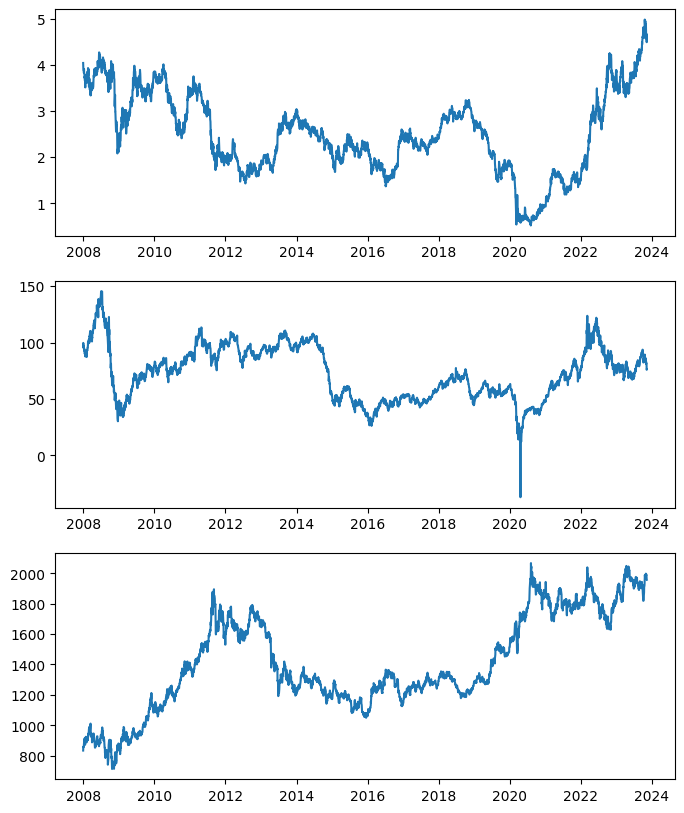

In [4]:
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed

ax1 = plt.subplot(311)  # Create the first subplot
ax1.plot(df['date'], df["bond"])

ax2 = plt.subplot(312)  # Create the second subplot
ax2.plot(df['date'], df["oil"])

ax3 = plt.subplot(313)  # Create the third subplot
ax3.plot(df['date'], df["gold"])

plt.show()

## Lag order selection

In [5]:
lag_order = select_order(data=df[['bond', 'oil', 'gold']], maxlags=10, deterministic="ci")
lag_order.summary()

c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_mo

,AIC,BIC,FPE,HQIC
0,1.069,1.092,2.912,1.077
1,1.011,1.047*,2.747,1.024
2,1.001*,1.052,2.722*,1.019*
3,1.004,1.068,2.728,1.026
4,1.002,1.081,2.725,1.030
5,1.005,1.097,2.731,1.037
6,1.001,1.107,2.722,1.039
7,1.003,1.122,2.726,1.045
8,1.001,1.135,2.722,1.049
9,1.003,1.151,2.728,1.055


## Cointegration rank

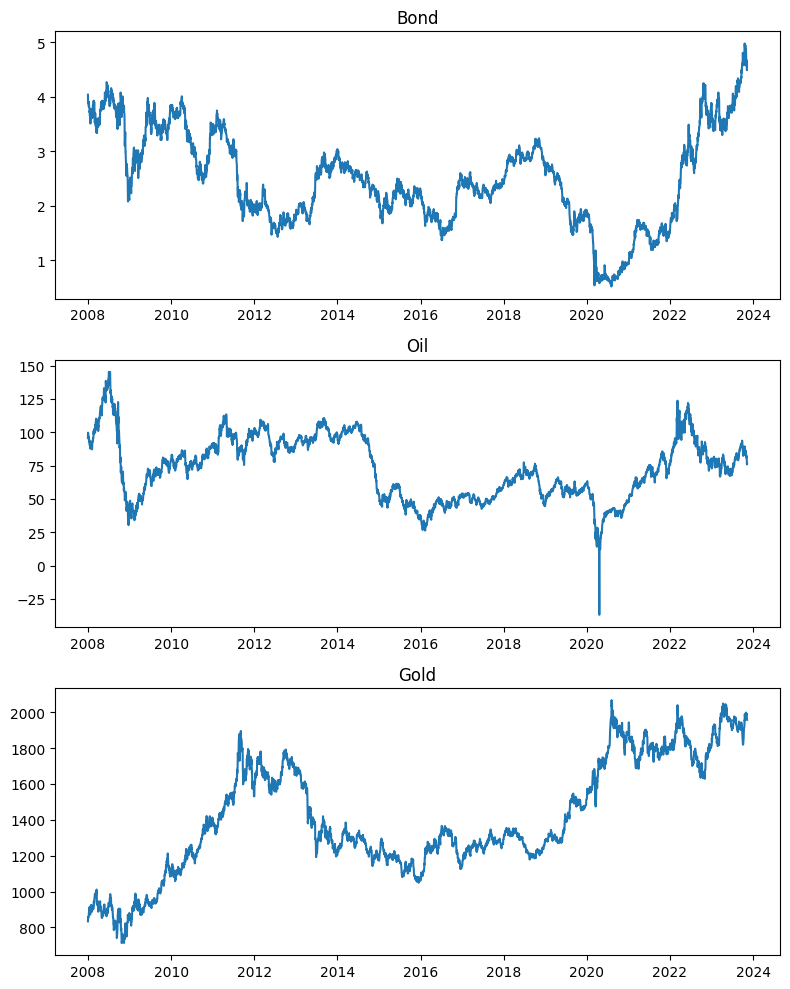

In [11]:
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed

ax1 = plt.subplot(311)  # Create the first subplot
ax1.plot(df['date'], df["bond"])
ax1.set_title('Bond')  # Set title for the first subplot

ax2 = plt.subplot(312)  # Create the second subplot
ax2.plot(df['date'], df["oil"])
ax2.set_title('Oil')  # Set title for the second subplot

ax3 = plt.subplot(313)  # Create the third subplot
ax3.plot(df['date'], df["gold"])
ax3.set_title('Gold')  # Set title for the third subplot

plt.tight_layout()  # Adjust subplots to prevent overlapping titles or axes
plt.show()

In [9]:
rank_test = select_coint_rank(df[['bond', 'oil', 'gold']], 1, lag_order.aic, method="maxeig",
                              signif=0.05)

print(rank_test.summary())
print(rank_test.rank)

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          14.76          24.25
-------------------------------------
0


Since the rank is 0, there is no cointegration relationship between the variables.
Thus we can use the VAR model to estimate the relationship between the variables.

In [ ]:
df_dff = df.diff().dropna()
lag_order = select_order(data=df_dff[['bond', 'oil', 'gold']], maxlags=10, deterministic="ci")
lag_order.summary()

c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_mo

,AIC,BIC,FPE,HQIC
0,1.010,1.033*,2.746,1.018
1,1.001*,1.038,2.721*,1.014*
2,1.003,1.054,2.727,1.021
3,1.002,1.067,2.724,1.025
4,1.004,1.083,2.730,1.032
5,1.001,1.093,2.721,1.034
6,1.003,1.108,2.725,1.040
7,1.001,1.121,2.721,1.043
8,1.003,1.136,2.726,1.050
9,1.003,1.150,2.726,1.055


# Granger causality test

In [173]:
from statsmodels.tsa.stattools import grangercausalitytests

# bonds and oil
#perform Granger-Causality test
# result = grangercausalitytests(df_diff[['bond', 'oil']], maxlag=[5]) # 1% sig

# # #perform Granger-Causality test
# result = grangercausalitytests(df_diff[['oil', 'bond']], maxlag=[23]) # 1 % sig

# bonds and gold
result = grangercausalitytests(df_diff[['bond', 'gold']], maxlag=[8]) # 1 % sig

#perform Granger-Causality test
result = grangercausalitytests(df_diff[['gold', 'bond']], maxlag=[1]) # 1% sig

# # Oil and gold
# result = grangercausalitytests(df_diff[['oil', 'gold']], maxlag=[10]) # 5% sig

# result = grangercausalitytests(df_diff[['gold', 'oil']], maxlag=[10]) # 1% sig


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.5129  , p=0.0005  , df_denom=4112, df_num=8
ssr based chi2 test:   chi2=28.2192 , p=0.0004  , df=8
likelihood ratio test: chi2=28.1232 , p=0.0005  , df=8
parameter F test:         F=3.5129  , p=0.0005  , df_denom=4112, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=58.3087 , p=0.0000  , df_denom=4133, df_num=1
ssr based chi2 test:   chi2=58.3510 , p=0.0000  , df=1
likelihood ratio test: chi2=57.9433 , p=0.0000  , df=1
parameter F test:         F=58.3087 , p=0.0000  , df_denom=4133, df_num=1


In [198]:
# bonds and oil
# #perform Granger-Causality test
# result = grangercausalitytests(df_diff[['bond', 'oil']], maxlag=[8]) # 1% sig

# # #perform Granger-Causality test
# result = grangercausalitytests(df_diff[['oil', 'bond']], maxlag=[24]) # 1 % sig

# # bonds and gold
# result = grangercausalitytests(df_diff[['bond', 'gold']], maxlag=[15]) # 1 % sig

# #perform Granger-Causality test
# result = grangercausalitytests(df_diff[['gold', 'bond']], maxlag=[1]) # 1% sig

# # Oil and gold
result = grangercausalitytests(df_diff[['oil', 'gold']], maxlag=[4]) # 5% sig

result = grangercausalitytests(df_diff[['gold', 'oil']], maxlag=[1]) # 1% sig


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7907  , p=0.0044  , df_denom=4124, df_num=4
ssr based chi2 test:   chi2=15.1959 , p=0.0043  , df=4
likelihood ratio test: chi2=15.1680 , p=0.0044  , df=4
parameter F test:         F=3.7907  , p=0.0044  , df_denom=4124, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=32.5299 , p=0.0000  , df_denom=4133, df_num=1
ssr based chi2 test:   chi2=32.5536 , p=0.0000  , df=1
likelihood ratio test: chi2=32.4261 , p=0.0000  , df=1
parameter F test:         F=32.5299 , p=0.0000  , df_denom=4133, df_num=1


# Model Selection

## AIC

In [348]:
from sklearn.model_selection import train_test_split

lag = 7

# Assuming 'df' is your original time series dataframe
df_diff = df.diff().dropna()
df_diff = df_diff[['bond', 'oil', 'gold']]

# Splitting the data into training and testing datasets
train_size = int(len(df_diff) * 0.80)
train, test = df_diff[0:train_size], df_diff[train_size:len(df_diff)]

# Creating the VAR model
model = VAR(train)
results = model.fit(lag)

# get the lag_order
lag_order = results.k_ar

# Forecasting (assuming 'steps' is the number of steps you want to forecast)
steps = len(test)
forecast = results.forecast(train.values[-lag_order:], steps=steps)

# Reverse differencing to obtain forecasts in the original scale
reversed_forecast_diff = pd.DataFrame(forecast, columns=['bond', 'oil', 'gold'])
reversed_forecast = reversed_forecast_diff.cumsum() + df[['bond', 'oil', 'gold']].iloc[-1]

c:\Users\ianda\Documents\GitHub\ts-learn\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [349]:
lag_order

7

## Granger causality test

In [352]:
from statsmodels.tsa.stattools import grangercausalitytests

# Extracting the residuals from the VAR model
residuals = results.resid

# Perform Granger causality tests
# For example, to test causality from 'oil' to 'gold' up to a lag of 5
maxlag = lag
# temp = grangercausalitytests(residuals[['oil', 'gold']], maxlag=[maxlag])
# temp = grangercausalitytests(residuals[['oil', 'bond']], maxlag=[maxlag])
# temp = grangercausalitytests(residuals[['bond', 'oil']], maxlag=[maxlag])
# temp = grangercausalitytests(residuals[['bond', 'gold']], maxlag=[maxlag])
# temp = grangercausalitytests(residuals[['gold', 'oil']], maxlag=[maxlag])
# temp = grangercausalitytests(residuals[['gold', 'bond']], maxlag=[maxlag])

## Evaluation of Model

In [343]:
# add the dates to the reversed_forecast
reversed_forecast['date'] = df['date'][train_size:len(df_diff)].reset_index(drop=True)

In [344]:
# merge reversed forecast with df on date column and add suffixes for prediction and actual
merged_df = pd.merge(df, reversed_forecast, on='date', how='left', suffixes=('_actual', '_prediction'))

In [355]:
# get the mape for each column
mape_oil = np.mean(np.abs(merged_df['oil_actual'] - merged_df['oil_prediction']) / np.abs(merged_df['oil_actual'])) * 100
mape_gold = np.mean(np.abs(merged_df['gold_actual'] - merged_df['gold_prediction']) / np.abs(merged_df['gold_actual'])) * 100
mape_bond = np.mean(np.abs(merged_df['bond_actual'] - merged_df['bond_prediction']) / np.abs(merged_df['bond_actual'])) * 100

# get MAE for oil and gold
mae_oil = np.mean(np.abs(merged_df['oil_actual'] - merged_df['oil_prediction']))
mae_gold = np.mean(np.abs(merged_df['gold_actual'] - merged_df['gold_prediction']))
mae_bond = np.mean(np.abs(merged_df['bond_actual'] - merged_df['bond_prediction']))

# get rmse
rmse_oil = np.sqrt(np.mean(np.square(merged_df['oil_actual'] - merged_df['oil_prediction'])))
rmse_gold = np.sqrt(np.mean(np.square(merged_df['gold_actual'] - merged_df['gold_prediction'])))
rmse_bond = np.sqrt(np.mean(np.square(merged_df['bond_actual'] - merged_df['bond_prediction'])))

In [356]:
print("RMSE",rmse_bond)
print("MAE",mae_bond)
print("MAPE",mape_bond)

RMSE 2.2205148418117426
MAE 1.8059239340442048
MAPE 132.36569115197364


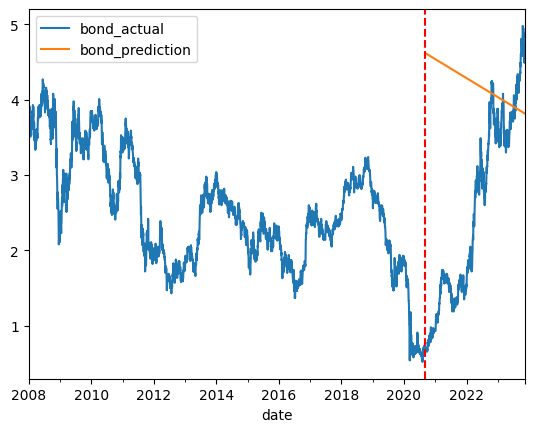

In [347]:
merged_df[['date','bond_actual', 'bond_prediction']].plot(x='date')
# add a stripped red line at df['date'][train_size:len(df_diff)].reset_index(drop=True)
plt.axvline(df['date'][train_size:len(df_diff)].reset_index(drop=True)[0], color='r', linestyle='--')

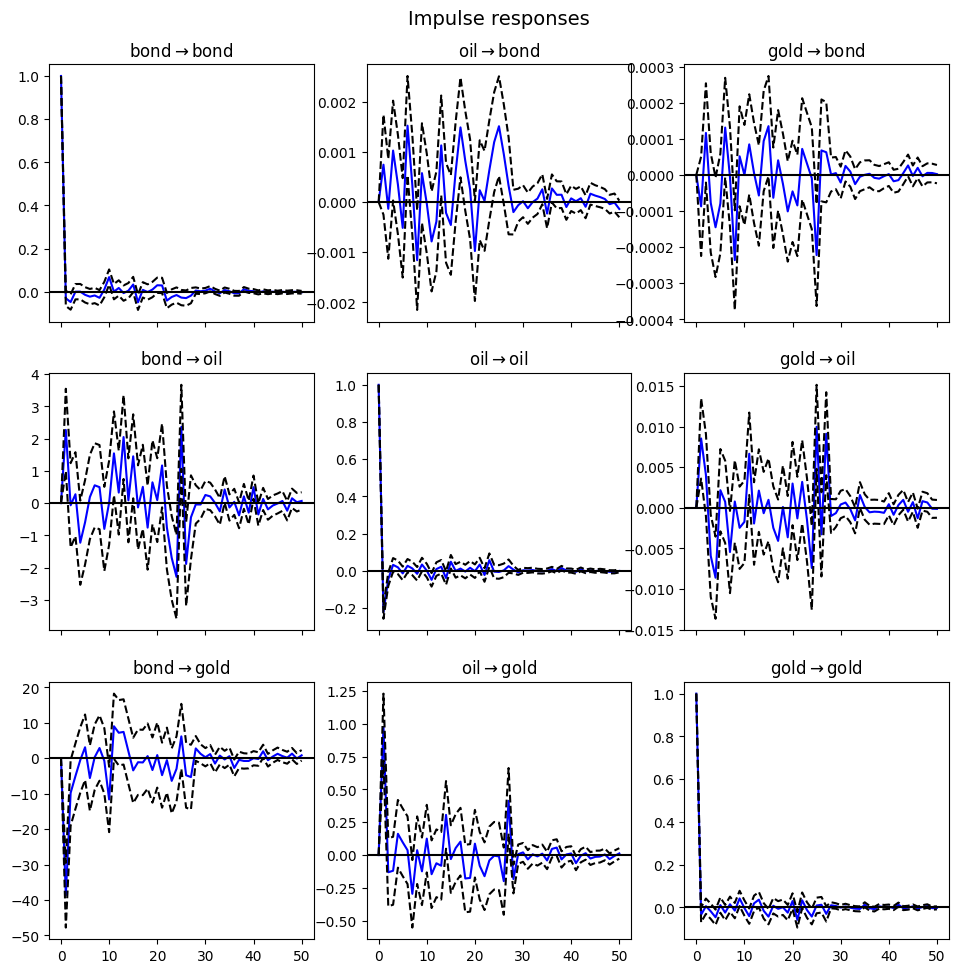

In [339]:
# impulse response analysis
irf = results.irf(50)
irf.plot(orth=False)
plt.show()
